# Notebook Lecture 11: Feedback Linearization
@2025 ETH Zurich, Niclas Scheuer, Oscar von Lohneysen, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Picture Source: https://www.nasa.gov/wp-content/uploads/2023/02/wff-2021-011-002.jpeg?w=2048

# Pitch Plane Trajectory Tracking Control via Adaptive Feedback Linearization

Based on the work "[Pitch Plane Trajectory Tracking Control for Sounding Rockets via Adaptive Feedback Linearization](https://arxiv.org/html/2501.05285v1#S3)" - Pedro does Santos, Paulo Oliveira


## Motivation

The control of a sounding rocket is generally _underactuated_, since the number of control inputs is less than the number of degrees-of-freedom. 

The classical approach is to decouple attitude (orientation) and position dynamics. An external loop controls the position by generating attitude commands, which an internal control loop tracks.

This demonstration investigates the use of feedback linearization to jointly address position and attitude control.

## Physical Model

### Reference Frames

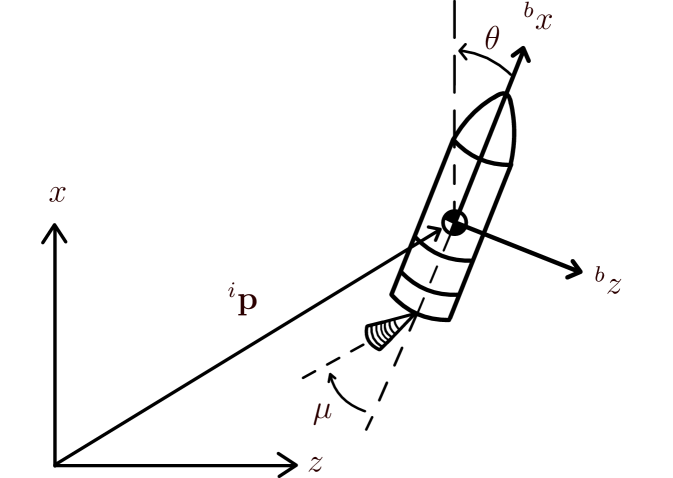


**Transformation between reference frames**
Reference frames: {inertial}, {body}

$$R_{i \leftarrow b} = \begin{bmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta \end{bmatrix}$$

### Forces
**Gravity (Inertial Frame)**
$${}^{i}f_g = \begin{bmatrix} -mg \\ 0 \end{bmatrix}$$
with $g = \frac{g_0 R_E^2}{(R_E + x)^2}$, where $g_0$ is the gravitational constant, $R_E$ is Earth radius, $x$ is altitude.

**Thrust (Body Frame)** 
Thrust vector:
$${}^{b}f_p = \begin{bmatrix} T \cdot \cos\mu \\ T \cdot \sin\mu \end{bmatrix}$$
Pitching moment:
$$\tau_p = T\cdot \sin\mu \cdot l$$
with $l$ being the distance between the engine gimbal and the center of mass.

**Mass Flow**
$$\dot{m} = -\frac{T}{I_{sp0}g_0} - \frac{p_a A_e}{I_{sp0} g_0}$$

**Aerodynamic Force (Body Frame)** 

Aerodynamic force vector:
$${}^{b}f_a = \begin{bmatrix} -\bar q C_A S \\ -\bar q C_N S \end{bmatrix}$$
with $C_A = C_D \cdot \cos\Lambda - C_L \cdot \sin\Lambda$ and $C_N = C_L \cdot \cos\Lambda + C_D \cdot \sin\Lambda$, the Lift and Drag coefficients $C_L$ and $C_D$, and angle of attack $\Lambda = atan2({}^{b}v_{rel,z}, {}^{b}v_{rel,x})$

Pitching moment:
$$\tau_a = {}^{b}f_{a_z} S M \bar d$$

### Equations of Motion
The equations of motion can be expressed as the following nonlinear MIMO system:

$${\begin{bmatrix} x \\ \dot{x} \\ z \\ \dot{z} \\ \theta \\ q \end{bmatrix}}' = \begin{bmatrix} \dot{x} \\ -g + \frac{{}^{i}f_{a_x}}{m} \\ \dot{z} \\ \frac{{}^{i}f_{a_z}}{m} \\ q \\ \frac{\tau_a}{I_y} \end{bmatrix}
+ \begin{bmatrix} 0 & 0 \\ \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & 0 \\ -\frac{\sin\theta}{m} & \frac{\cos\theta}{m} \\ 0 & 0 \\ 0 & \frac{l}{I_y} \end{bmatrix} 
\begin{bmatrix} T \cdot \cos\mu \\ T \cdot \sin\mu \end{bmatrix}$$
$$y = \begin{bmatrix} x \\ z \\ \theta \end{bmatrix}$$

## Inner Loop
The inner loop (attitude control) receives an altitude $x_d$ and pitch $\theta_d$ command. The errors $e_x = x - x_d$ and $e_{\theta} = \theta - \theta_d$ should be minimized.

$${\begin{bmatrix} e_x \\ \dot{e}_x \\ e_{\theta} \\ \dot{e}_{\theta} \end{bmatrix}}' = \begin{bmatrix} \dot{e}_x \\ -g + \frac{{}^{i}f_{a_x}}{m} - \ddot{x}_d \\ \dot{e}_{\theta} \\ \frac{\tau_a}{I_y} - \ddot{\theta}_d \end{bmatrix} + \begin{bmatrix} 0 & 0 \\ \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & 0 \\ 0 & \frac{l}{I_y} \end{bmatrix} \begin{bmatrix} T \cdot \cos\mu \\ T \cdot \sin\mu \end{bmatrix}$$
$$y_{in} = \begin{bmatrix} e_x \\ e_{\theta} \end{bmatrix}$$

By taking the derivatives of $y_{in}$ with respect to time, we find that the input $u_{in}$ appears at relative degree $r_{in} = \{2, 2\}$. Therefore, we create the static state feedback law:
$$u_{in} = -\Lambda_{in}^{-1}(x_{in}) b_{in}(x_{in}) + \Lambda_{in}^{-1}(x_{in})v_{in}$$
with:
$$\Lambda_{in}(x_{in}) = \begin{bmatrix} \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & \frac{l}{I_y} \end{bmatrix}$$
$$b_{in}(x_{in}) = \begin{bmatrix} -g + \frac{{}^{i}f_{a_x}}{m} - \ddot{x}_d \\ \frac{\tau_a}{I_y} - \ddot{\theta}_d \end{bmatrix}$$

In [20]:
import numpy as np
import control as ct
import control.flatsys as fs
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from numpy.typing import NDArray

from scipy.integrate import solve_ivp

In [170]:
def simulate(f, u, t_span, x0, t_eval):
    sol = solve_ivp(fun=lambda t, x: f(t, x, u(t)), t_span=t_span, y0=x0, t_eval=t_eval, rtol=1e-9, atol=1e-12)
    return t_eval, sol.y

### Constants

In [33]:
l = 8 # length
# m (float): Mass.
# g0 (float): Gravitational constant at Earth's surface.
# R_E (float): Earth radius
R_E = 6371*10e3
N_A = 6.022169e26
g0 = 9.80665
M0 = 28.9644
R = 8.31432e3
T0 = 288.15 
p0 = 101325

A_e = 0.2**2 *3.14 # Nozzle exit area. guess

I_y = 3100
d_bar = 0.5 # reference length, usually the maximum diameter of the fuselage
x_cp = 8 # center of pressure location guess, should be obtained using Computational Fluid Dynamic
x_cm = 4.18
SM = (x_cp - x_cm)/d_bar # static stability margin.
Isp0 = 300 

S = d_bar**2/4*np.pi    #reference area, typically the fuselage cross-sectional area. 

C_L = 0.01 #guess
C_D = 0.5   #guess


In [114]:

def atmo_temp(alt):
    """
    Atmospheric Temperature Calculation (1976 Standard Atmosphere)

    Parameters:
    alt : float
        Geometric altitude in kilometers (must be between 0 and 1000 km)

    Returns:
    Temp : float
        Temperature at the given altitude in Kelvin
    """

    # Constants
    r_E = 6356.766  # Earth radius in km
    epsilon = 1e5 * np.finfo(float).eps

    # Temperatures at atmospheric layers [K]
    T = np.array([288.15, 216.65, 216.65, 228.65, 270.65, 270.65,
                  214.65, 186.95, 186.8673, 240, 360, 1000])
    
    # Lapse rates [K/km]
    L = np.array([-6.5, 0, 1, 2.8, 0, -2.8, -2, 0, 0, 12, 0])

    # Geometric altitudes < 86 km (converted from geopotential)
    H = np.array([0, 11, 20, 32, 47, 51, 71])
    Z = r_E * H / (r_E - H)

    # Altitudes > 86 km (set directly)
    Z = np.concatenate((Z, [86, 91, 110, 120, 1000]))

    # Bounds check
    if alt < Z[0] or alt > Z[11] + epsilon:
        raise ValueError("Altitude must be between 0 and 1000 km")

    # Below or at 86 km: interpolation of molecular temperature
    if Z[0] <= alt <= Z[7]:
        Temp = np.interp(alt, Z[:8], T[:8])

    # Between 86 km and 91 km
    elif Z[7] < alt <= Z[8]:
        Temp = T[8]

    # Between 91 km and 110 km: special non-linear expression
    elif Z[8] < alt <= Z[9]:
        a = 19.9429
        A = -76.3232
        T_c = 263.1905
        Temp = T_c + A * np.sqrt(1 - ((alt - Z[8]) / a)**2)

    # Between 110 km and 120 km: interpolate
    elif Z[9] < alt <= Z[10]:
        Temp = np.interp(alt, Z[9:11], T[9:11])

    # Above 120 km to 1000 km: exponential decay
    else:
        lambda_ = L[9] / (T[11] - T[10])
        xi = (alt - Z[10]) * (r_E + Z[10]) / (r_E + alt)
        Temp = T[11] - (T[11] - T[10]) * np.exp(-lambda_ * xi)

    return Temp

def atmo_p(alt, T=None, sum_n=None):
    """
    Atmospheric Pressure Calculation
    Author:     Brent Lewis (Original MATLAB Code)
    Translated to Python by OpenAI's ChatGPT

    Parameters:
    alt : array_like
        Geometric altitude vector [km]
    T : array_like or None, optional
        Temperature vector at given altitude points [K]
        Required only for altitudes > 86 km
    sum_n : array_like or None, optional
        Total number density of atmospheric gases [1/m^3]

    Returns:
    P : ndarray
        Pressure vector [Pa]
    """

    # Constants
    N_A = 6.022169e26  # Avogadro's number [1/kmol]
    g_0 = 9.80665      # gravitational acceleration [m/s^2]
    M_0 = 28.9644      # molar mass of air [kg/kmol]
    R = 8.31432e3      # universal gas constant [J/(kmol*K)]
    r_E = 6.356766e3   # Earth radius [km]

    # Layers defined by altitude for < 86 km
    H = np.array([0, 11, 20, 32, 47, 51, 71, 84.852])
    Z = r_E * H / (r_E - H)
    Z[-1] = 86  # adjust final value

    # Standard atmosphere properties at each layer
    T_M_B = np.array([288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65])
    L = np.array([-6.5, 0, 1, 2.8, 0, -2.8, -2]) / 1e3
    P_ref = np.array([1.01325e5, 2.2632e4, 5.4748e3,
                      8.6801e2, 1.1090e2, 6.6938e1, 3.9564])

    # Ensure numpy array and initialize output
    alt = np.atleast_1d(alt)
    P = np.zeros_like(alt)

    for i in range(len(alt)):
        Z_i = alt[i]
        if sum_n is None:
            index = np.where(Z >= Z_i)[0]
            if len(index) == 0:
                idx = len(Z) - 2
            else:
                idx = index[0] - 1
            if Z_i == 0:
                idx = 0

            Z_H = r_E * Z_i / (r_E + Z_i)  # Geopotential altitude

            if L[idx] == 0:
                P[i] = P_ref[idx] * np.exp(-g_0 * M_0 * (Z_H - H[idx]) * 1e3 /
                                           (R * T_M_B[idx]))
            else:
                term = 1 + (L[idx] * (Z_H - H[idx]) * 1e3) / T_M_B[idx]
                if term <= 0:
                    P[i] = 0  # or some minimum pressure
                else:
                    P[i] = P_ref[idx] * term ** (-g_0 * M_0 / (R * L[idx]))
        else:
            P[i] = sum_n[i] * R * T[i] / N_A

    return P

In [115]:
R_ib = lambda theta: np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])

def g(x, m, R_E , g0):
    """
    Computes the gravity force in the inertial frame.
    
    Parameters:
.
        x (float): Altitude.
    
    Returns:
        np.ndarray: Gravity force vector [ -m*g, 0 ].
    """
    g = g0 * (R_E**2) / (R_E + x)**2
    return np.array([-m * g, 0.0])

#thrust_force_body
f_p_b = lambda T, mu : np.array([T * np.cos(mu), T * np.sin(mu)])

t_p = lambda T, mu: T * np.sin(mu) * l

def m_dot(T, Isp0, g0, p_a, A_e):
    """
    Computes the mass flow rate.
    
    Parameters:
        T (float): Thrust magnitude.
        Isp0 (float): Specific impulse at zero altitude.
        g0 (float): Gravitational constant.
        p_a (float): Ambient pressure.
        A_e (float): Nozzle exit area.
    
    Returns:
        float: Mass flow rate (negative value).
    """
    return (-T - p_a * A_e) / (Isp0 * g0)

def f_a_b(q_bar, C_D, C_L, S, b_v_rel_x, b_v_rel_z):
    """
    Computes the aerodynamic force vector in the body frame.
    
    Parameters:
        q_bar (float): Dynamic pressure.
        C_D (float): Drag coefficient.
        C_L (float): Lift coefficient.
        S (float): Reference area.
        b_v_rel_x (float): x-component of relative velocity in body frame.
        b_v_rel_z (float): z-component of relative velocity in body frame.
    
    Returns:
        np.ndarray: Aerodynamic force vector [ f_a_x, f_a_z ].
    """
    Lambda = np.arctan2(b_v_rel_z, b_v_rel_x)
    cos_Lambda = np.cos(Lambda)
    sin_Lambda = np.sin(Lambda)
    C_A = C_D * cos_Lambda - C_L * sin_Lambda
    C_N = C_L * cos_Lambda + C_D * sin_Lambda
    f_a_x = -q_bar * C_A * S
    f_a_z = -q_bar * C_N * S
    return np.array([f_a_x, f_a_z])

def t_a(f_a_z, SM, d_bar):
    """
    Computes the aerodynamic pitching moment.
    
    Parameters:
        f_a_z (float): z-component of aerodynamic force in body frame.
        SM:  static stability margin.
        d_bar (float): reference length, usually the maximum diameter of the fuselage
    
    Returns:
        float: Aerodynamic pitching moment.
    """
    return f_a_z * SM * d_bar

In [175]:
def nonlinear_sys(t, state: NDArray[np.float64], u: NDArray[np.float64]) -> NDArray[np.float64]:
    print(state)
    x, x_dot, z, z_dot, theta, q, m = state
    T, mu = u
    v_wind = np.array([0,0])
    b_v_rel_x, b_v_rel_z = x_dot - v_wind[0], z_dot - v_wind[1]

    if x/1000 < 1000:
        temp = atmo_temp(x/1000)
        p_a = atmo_p(x/1000, temp)[0]
    else:
        temp = 3
        p_a = 0
        
    rho = p_a * M0 / (R * temp)
    #dynamic pressure 
    q_bar = rho * x_dot**2 / 2
    f_a_b_ =  f_a_b(q_bar, C_D, C_L, S, b_v_rel_x, b_v_rel_z)

    return np.array([
        x_dot,
        (-g(x, m, R_E, g0)[0] + (R_ib(theta) @ f_a_b_)[0]/m),
        z_dot,
        (R_ib(theta) @ f_a_b_)[1]/m,
        q,
        t_a(f_a_b_[1],SM,  d_bar)/I_y,
        m_dot(T, Isp0, g0, p_a, A_e)
    ]) + np.array([
        [0,0],
        [np.cos(theta)/m, np.sin(theta)/m],
        [0,0],
        [-np.sin(theta)/m, np.cos(theta)/m],
        [0,0],
        [0, l/I_y],
        [0,0]
    ]) @ f_p_b(T, mu)

def nonlinear_sys_output(state: NDArray[np.float64], u: NDArray[np.float64]) -> NDArray[np.float64]:
    x, x_dot, z, z_dot, theta, q = state
    return np.array([x,z,theta])

In [176]:
t_span = (1, 7)
t_eval = np.linspace(*t_span, 8000)
t,  y1_lin     = simulate(nonlinear_sys, lambda t: np.array([1250*9.8*1.01, 0.05 * t]) if t < 3 else np.array([0,0]),   t_span, np.array([0,0,0,0,0,0,1250]), t_eval)

[   0.    0.    0.    0.    0.    0. 1250.]
[0.00000000e+00 9.99999191e-06 0.00000000e+00 4.03232334e-10
 0.00000000e+00 1.30074947e-09 1.25000000e+03]
[0.00000000e+00 1.99999838e-04 0.00000000e+00 8.06464669e-09
 0.00000000e+00 2.60149893e-08 1.25000000e+03]
[3.66801438e-12 2.99999757e-04 1.47906320e-16 1.20969702e-08
 4.77117161e-16 3.90224845e-08 1.25000000e+03]
[2.60836578e-11 7.99999353e-04 1.05177832e-15 3.22585878e-08
 3.39283328e-15 1.04059961e-07 1.25000000e+03]
[3.22020467e-11 8.88888170e-04 1.29849179e-15 3.58428755e-08
 4.18868320e-15 1.15622179e-07 1.25000000e+03]
[4.07557153e-11 9.99999191e-04 1.64340366e-15 4.03232351e-08
 5.30130212e-15 1.30074952e-07 1.25000000e+03]
[4.07557154e-11 9.99999191e-04 1.64340360e-15 4.03232351e-08
 5.30130193e-15 1.30074952e-07 1.25000000e+03]
[2.03778577e-10 2.99999757e-03 8.21701809e-15 1.20969709e-07
 2.65065099e-14 3.90224866e-07 1.25000000e+03]
[6.52091445e-10 3.99999676e-03 2.62944585e-14 1.61292960e-07
 8.48208339e-14 5.20299871e-07 

In [177]:
y1_lin

array([[ 0.00000000e+00,  3.45128742e-03,  1.38051239e-02, ...,
         2.15600295e+05,  2.15654434e+05,  2.15708579e+05],
       [ 0.00000000e+00,  9.20227434e+00,  1.84044955e+01, ...,
         7.21711451e+04,  7.21801849e+04,  7.21892248e+04],
       [ 0.00000000e+00,  1.39198395e-07,  5.56885203e-07, ...,
        -2.97168432e+03, -2.97209801e+03, -2.97251170e+03],
       ...,
       [ 0.00000000e+00,  4.49033436e-07,  1.79651161e-06, ...,
         5.93412801e+02,  5.93503895e+02,  5.93594989e+02],
       [ 0.00000000e+00,  1.19740662e-03,  2.39552169e-03, ...,
         1.21443527e+02,  1.21443527e+02,  1.21443527e+02],
       [ 1.25000000e+03,  1.24999360e+03,  1.24998720e+03, ...,
         1.23725499e+03,  1.23725499e+03,  1.23725499e+03]],
      shape=(7, 8000))

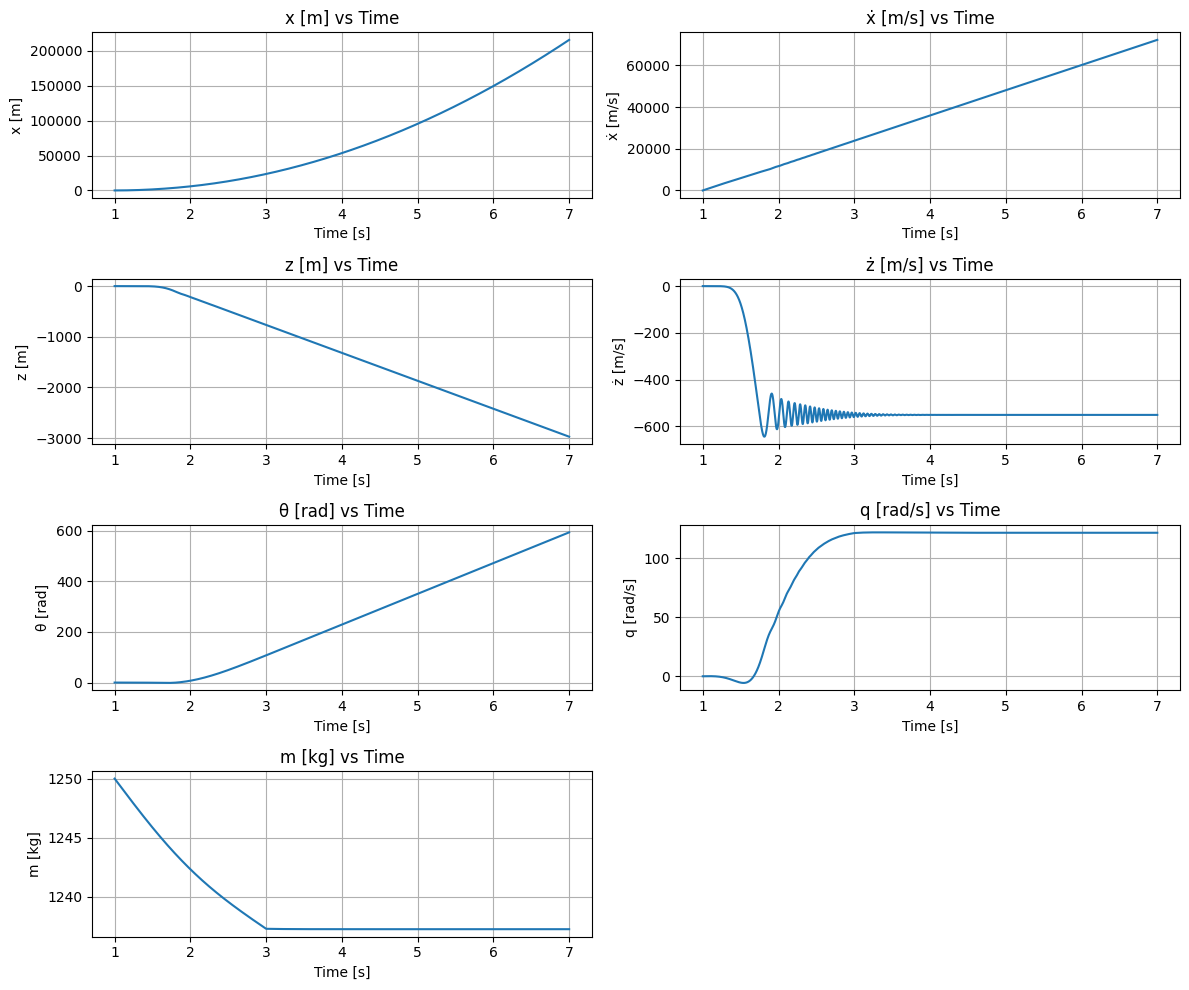

In [178]:
# Labels for each state variable (adjust if your variable names differ)
labels = ["x [m]", "ẋ [m/s]", "z [m]", "ż [m/s]", "θ [rad]", "q [rad/s]", "m [kg]"]

plt.figure(figsize=(12, 10))
for i in range(7):
    plt.subplot(4, 2, i + 1)
    plt.plot(t, y1_lin[i])
    plt.xlabel("Time [s]")
    plt.ylabel(labels[i])
    plt.grid(True)
    plt.title(f"{labels[i]} vs Time")

plt.tight_layout()
plt.show()

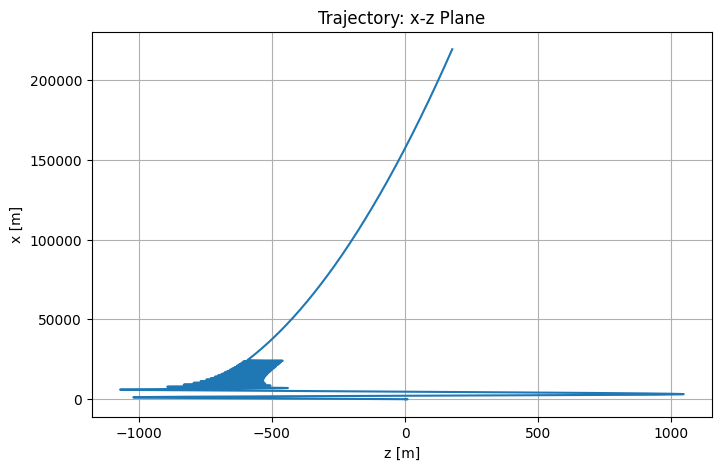

In [163]:
import matplotlib.pyplot as plt

x = y1_lin[0]
z = y1_lin[1]

plt.figure(figsize=(8, 5))
plt.plot(z, x)
plt.xlabel("z [m]")
plt.ylabel("x [m]")
plt.title("Trajectory: x-z Plane")
plt.grid(True)
plt.show()

In [ ]:
def innerloop_dynamics(t, x_in: np.array[float], u_in: np.array[float], params) -> np.array[float]:
    e_x, e_x_dot, e_theta, e_theta_dot = x_in
    theta = params["theta"]
    x_d_ddot = params["x_d_ddot"]
    theta_d_ddot = params["theta_d_ddot"]
    
    return np.array([
        e_x_dot,
        - g + (R_ib(theta) @ f_a_b(q_bar, C_D, C_L, S, b_v_rel_x, b_v_rel_z))[0]/m - x_d_ddot,
        e_theta_dot,
        t_a(f_a_z, d_bar)/I_y - theta_d_ddot
    ]) + np.array([
        [0,0],
        [np.cos(theta)/m, np.sin(theta)/m],
        [-np.sin(theta), np.cos(theta)],
        [0,0],
        [0, l/I_y]
    ]) @ u_in 

def innerloop_output(t, x_in: np.array[float], u_in: np.array[float], params) -> np.array[float]:
    e_x, e_x_dot, e_theta, e_theta_dot = x_in
    return np.array([e_x,e_theta])

In [ ]:
innerloop_sys = ct.NonlinearIOSystem(innerloop_dynamics, innerloop_output)
xeq, ueq = ct.find_eqpt(innerloop_sys, X0, U0)
ss_sys = ct.linearize(innerloop_sys, xeq, ueq)

In [ ]:
Lambda_in = np.array([np.cos(theta)/m, np.sin(theta)/m,
                      0, l/I_y])

b_in = np.array([ - g + (R_ib(theta) @ f_a_b(q_bar, C_D, C_L, S, b_v_rel_x, b_v_rel_z))[0]/m - x_d_ddot, t_a(f_a_z, d_bar)/I_y - theta_d_ddot])

u_in = - np.linalg.inv(Lambda_in) @ b_in + np.linalg.inv(Lambda_in) @ v_in

$$u_{in} = -\Lambda_{in}^{-1}(x_{in}) b_{in}(x_{in}) + \Lambda_{in}^{-1}(x_{in})v_{in}$$
with:
$$\Lambda_{in}(x_{in}) = \begin{bmatrix} \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & \frac{l}{I_y} \end{bmatrix}$$
$$b_{in}(x_{in}) = \begin{bmatrix} -g + \frac{{}^{i}f_{a_x}}{m} - \ddot{x}_d \\ \frac{\tau_a}{I_y} - \ddot{\theta}_d \end{bmatrix}$$